# SPARK v1.2 Image Preprocessing Script Breakdown

This notebook serves to explain how SPARK v1.1 (short for Skin Pattern Analysis and Recognition Kit version 1.1), the image preprocessing Python script that accompanies HOTARU v1.2, works step by step.

In [1]:
# Path of image
path = "img_data/test/1/ISIC_0534674.JPG"

In [2]:
# Importing relevant packages
from PIL import Image
import os
import scipy as sp
import skimage as ski
from skimage import io, color, exposure
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2

In [3]:
# Creating function to show images - this function is not part of SPARK and is here for demonstrative purposes.
def show_image(image, title='Image', cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

## Step 1: Translating image into array

In this step, the input image is received and immediately reshaped into 300x300 (RGB), the shape which HOTARU was trained on. 300x300 was decided to be the size to use as the size is a compromise between having a small file to analyse which also retains the detail necessary to detect skin cancer. Then, the image is converted into a NumPy array to make it easier for transformations to be done. Normalisation was also done.

In [4]:
# Open the image using Pillow - in the Python file, this line is replaced with a line which receives an input.
img = Image.open(path)

# Resize the image to a consistent size (e.g., 224x224)
img = img.resize((300, 300))

# Convert the image to a NumPy array
img_array = np.array(img)

# Normalize pixel values
img_array = cv2.normalize(img_array, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

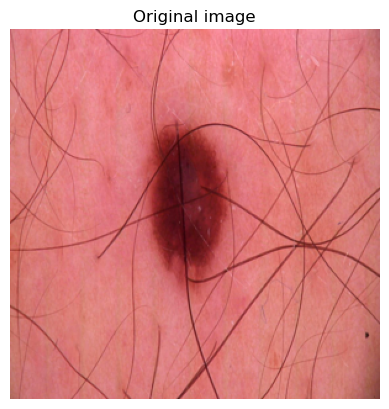

In [5]:
# Showing image
show_image(img_array, title='Original image')

# Step 2.1: Creating the mask - Removing body hair with DullRazor algorithm

In the first part of Step 2, SPARK will create a new image that removes any body hair that is part of the original input image. This image is then used for masking purposes. By removing body hair, the masking process can be more accurate at segmenting the important feature (in this case, the skinspot). This part of the process was made possible by the [DullRazor algorithm](https://github.com/BlueDokk/Dullrazor-algorithm), an algorithm that serves to remove body hair from dermoscopic images by using a handful of morphology techniques.

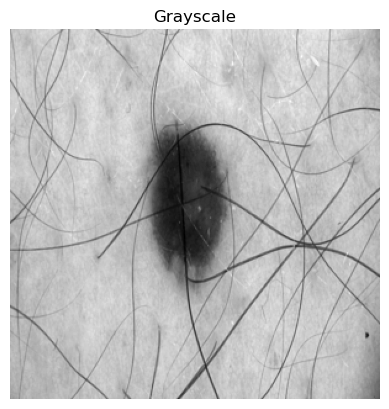

In [6]:
# Converting RGB picture to greyscale for thresholding
img_gc = color.rgb2gray(img_array)
show_image(img_gc, title="Grayscale")

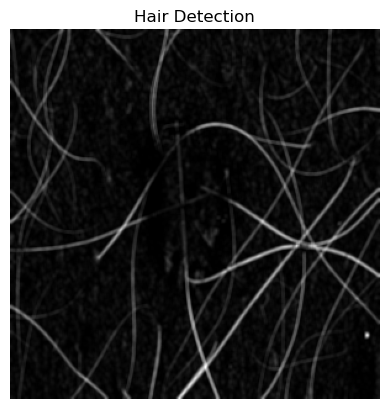

In [7]:
#Black hat filter
kernel = cv2.getStructuringElement(1,(9,9))
blackhat = cv2.morphologyEx(img_gc, cv2.MORPH_BLACKHAT, kernel)
#Gaussian filter
bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

show_image(bhg, title='Hair Detection')

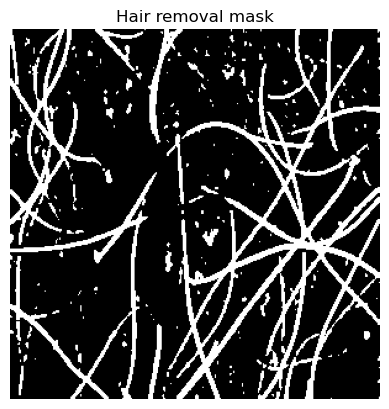

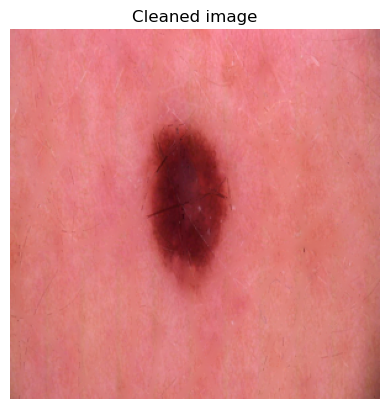

In [8]:
#Binary thresholding (MASK)
ret,mask = cv2.threshold(bhg,0.03,255,cv2.THRESH_BINARY)

# Normalise mask
mask = cv2.normalize(mask, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

#Replace pixels of the mask
dst = cv2.inpaint(img_array,mask,6,cv2.INPAINT_TELEA)

show_image(mask, title='Hair removal mask')
show_image(dst, title='Cleaned image')

# Step 2.2: Creating the mask - Utilising cleaned image to segment skinspot/lesion.

In this step, otsu thresholding is implemented on the cleaned image to create a mask that isolates the skinspot from the rest of the skin. Prior to thresholding, contrast is adjusted as best as possible to ensure accurate thresholding. It should be noted that these measures are sometimes not very effective, leading to pictures where a ring of skin on the borders of the processed photo appear.

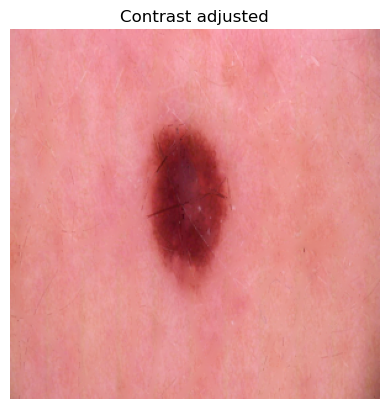

In [9]:
# Contrast adjustment - logarithmic method 
img_ex1 = exposure.adjust_log(dst)

show_image(img_ex1, title='Contrast adjusted')

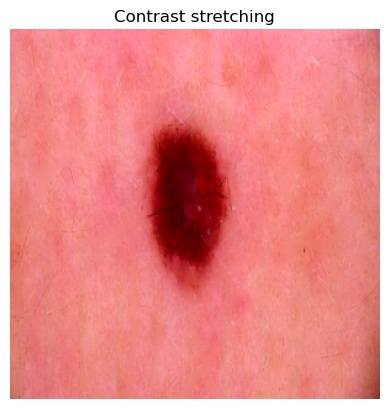

In [10]:
# Contrast streching

p2, p98 = np.percentile(img_ex1, (2, 98))
img_ex2 = exposure.rescale_intensity(img_ex1, in_range=(p2, p98))

show_image(img_ex2, title='Contrast stretching')

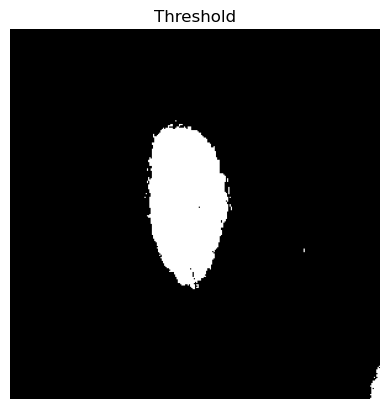

In [11]:
# Global thresholding with Otsu
from skimage.filters import threshold_otsu

# Converting cleaned photo into greyscale for thresholding
img_ex2 = color.rgb2gray(img_ex2)

# Thresholding
thresh = threshold_otsu(img_ex2)

# creating threshold image
img_t = img_ex2 <= thresh

show_image(img_t, title='Threshold')

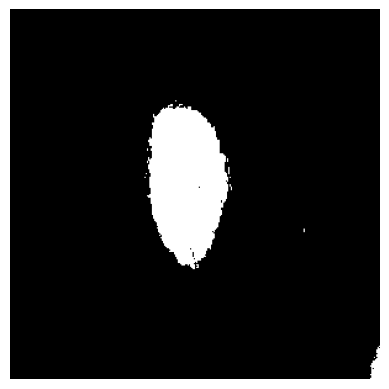

In [12]:
# Creating mask using threshold image
# Value 0 as black and white photo used
mask = np.where(img_t >= 0, img_t, 0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

## Step 3: Creating processed photo

In this step, a nested for loop is utilised to create a final photo that is made by overlaying the created mask that isolates the skinspot on the original input photo.

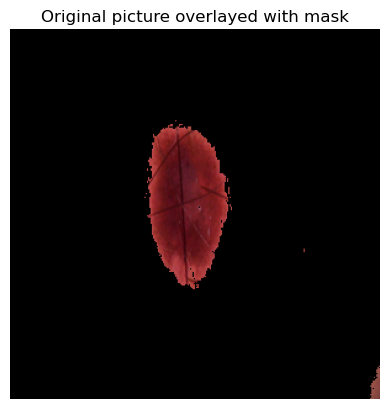

In [13]:
# Overlaying mask on original image
# So that model will receive only skinmark (the less pixels to consider, the faster processing becomes)

# Nested for loop for each 'row' of img
for h in range(mask.shape[0]):
  # For each 'column' of img
    for w in range(mask.shape[1]):
      # If the pixel chosen from the mask is white, add in the pixel from the original image
      # Otherwise, discard/make pixel black
        if mask[h][w] == 0:
            for i in range(3):
                img_array[h][w][i] = 0
        else:
            continue

show_image(img_array, title='Original picture overlayed with mask')